### 1. Load Train / Test / Validation Data Files

In [6]:
import numpy as np

In [7]:
train_features_path =  "../../template/ICDAR-feature/train_features.npy"
train_names_path = "../../template/ICDAR-feature/train_names.npy"
train_labels_path = "../../template/ICDAR-feature/train_labels.npy"

test_features_path = "../../template/ICDAR-feature/test_features.npy"
test_names_path = "../../template/ICDAR-feature/test_names.npy"
test_labels_path = "../../template/ICDAR-feature/test_labels.npy"

validation_features_path = "../../template/ICDAR-feature/validation_features.npy"
validation_names_path = "../../template/ICDAR-feature/validation_names.npy"
validation_labels_path = "../../template/ICDAR-feature/validation_labels.npy"

train_features = np.load(train_features_path)
train_names = np.load(train_names_path)
train_labels = np.load(train_labels_path)

test_features = np.load(test_features_path)
test_names = np.load(test_names_path)
test_labels = np.load(test_labels_path)

validation_features = np.load(validation_features_path)
validation_names = np.load(validation_names_path)
validation_labels = np.load(validation_labels_path)

In [8]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)
print(validation_features.shape)
print(validation_labels.shape)

(857, 512)
(857,)
(401, 512)
(401,)
(391, 512)
(391,)


### 2. Train on ML

In [9]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [10]:
model = svm.SVC()
model.fit(train_features, train_labels)

SVC()

### 3. Hyperparameter Tuning

In [11]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(svm.SVC(), param_grid, cv=5)
grid_search.fit(validation_features, validation_labels)
best_params = grid_search.best_params_

### 4. Test

In [12]:
best_model = svm.SVC(**best_params)
best_model.fit(train_features , train_labels)
test_pred = best_model.predict(test_features)
accuracy = accuracy_score(test_labels, test_pred)

In [13]:
print(accuracy)

0.9576059850374065


### 5. ROC Curve

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

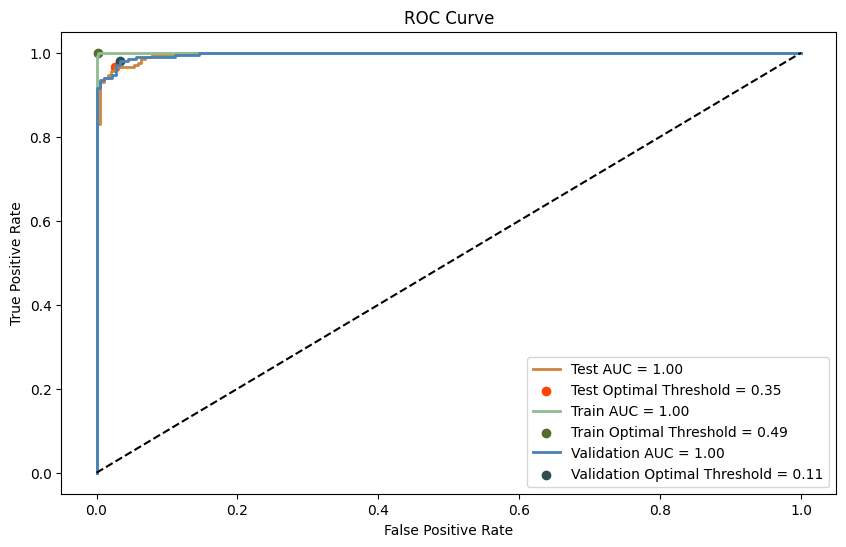

In [15]:
# Predict probabilities for each class
y_train_prob = best_model.decision_function(train_features)
y_test_prob = best_model.decision_function(test_features)
y_val_prob = best_model.decision_function(validation_features)

# Compute ROC curve and AUC for each set
fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, y_train_prob, drop_intermediate=False)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, thresholds_test = roc_curve(test_labels, y_test_prob, drop_intermediate=False)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_val, tpr_val, thresholds_val = roc_curve(validation_labels, y_val_prob, drop_intermediate=False)
roc_auc_val = auc(fpr_val, tpr_val)

# Calculate Youden's J statistic
J_values_test = tpr_test - fpr_test
optimal_idx_test = np.argmax(J_values_test)
optimal_threshold_test = abs(thresholds_test[optimal_idx_test])
J_values_train = tpr_train - fpr_train
optimal_idx_train = np.argmax(J_values_train)
optimal_threshold_train = abs(thresholds_train[optimal_idx_train])
J_values_val = tpr_val - fpr_val
optimal_idx_validation = np.argmax(J_values_val)
optimal_threshold_val = abs(thresholds_val[optimal_idx_validation])

# Plot ROC curve
plt.figure(figsize=(10, 6))

plt.plot(fpr_test, tpr_test, color='peru', lw=2, label=f'Test AUC = {roc_auc_test:.2f}')
plt.scatter(fpr_test[optimal_idx_test], tpr_test[optimal_idx_test], marker='o', color='orangered', label=f'Test Optimal Threshold = {optimal_threshold_test:.2f}')
plt.plot(fpr_train, tpr_train, color='darkseagreen', lw=2, label=f'Train AUC = {roc_auc_train:.2f}')
plt.scatter(fpr_train[optimal_idx_train], tpr_train[optimal_idx_train], marker='o', color='darkolivegreen', label=f'Train Optimal Threshold = {optimal_threshold_train:.2f}')
plt.plot(fpr_val, tpr_val, color='steelblue', lw=2, label=f'Validation AUC = {roc_auc_val:.2f}')
plt.scatter(fpr_val[optimal_idx_validation], tpr_val[optimal_idx_validation], marker='o', color='darkslategray', label=f'Validation Optimal Threshold = {optimal_threshold_val:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [16]:
def find_tpr_at_fpr(fpr, tpr, target_fpr):
    return np.interp(target_fpr, fpr, tpr)

In [17]:
target_fprs = [0.1, 0.01, 0.001]
tpr_at_target_fpr_train = [find_tpr_at_fpr(fpr_train, tpr_train, fpr) for fpr in target_fprs]
tpr_at_target_fpr_test = [find_tpr_at_fpr(fpr_test, tpr_test, fpr) for fpr in target_fprs]
tpr_at_target_fpr_val = [find_tpr_at_fpr(fpr_val, tpr_val, fpr) for fpr in target_fprs]

In [18]:
print(tpr_test)

[0.         0.00471698 0.00943396 0.01415094 0.01886792 0.02358491
 0.02830189 0.03301887 0.03773585 0.04245283 0.04716981 0.05188679
 0.05660377 0.06132075 0.06603774 0.07075472 0.0754717  0.08018868
 0.08490566 0.08962264 0.09433962 0.0990566  0.10377358 0.10849057
 0.11320755 0.11792453 0.12264151 0.12735849 0.13207547 0.13679245
 0.14150943 0.14622642 0.1509434  0.15566038 0.16037736 0.16509434
 0.16981132 0.1745283  0.17924528 0.18396226 0.18867925 0.19339623
 0.19811321 0.20283019 0.20754717 0.21226415 0.21698113 0.22169811
 0.22641509 0.23113208 0.23584906 0.24056604 0.24528302 0.25
 0.25471698 0.25943396 0.26415094 0.26886792 0.27358491 0.27830189
 0.28301887 0.28773585 0.29245283 0.29716981 0.30188679 0.30660377
 0.31132075 0.31603774 0.32075472 0.3254717  0.33018868 0.33490566
 0.33962264 0.34433962 0.3490566  0.35377358 0.35849057 0.36320755
 0.36792453 0.37264151 0.37735849 0.38207547 0.38679245 0.39150943
 0.39622642 0.4009434  0.40566038 0.41037736 0.41509434 0.41981132
 

In [19]:
print(fpr_test)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [20]:
print("Test")
for tpr, fpr in zip(tpr_at_target_fpr_test, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_test}')

print("Train")
for tpr, fpr in zip(tpr_at_target_fpr_train, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_train}')

print("Validation")
for tpr, fpr in zip(tpr_at_target_fpr_val, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_val}')

Test
TPR at FPR 0.100: 0.995
TPR at FPR 0.010: 0.929
TPR at FPR 0.001: 0.830
             AUC: 0.9964061096136567
Train
TPR at FPR 0.100: 1.000
TPR at FPR 0.010: 1.000
TPR at FPR 0.001: 0.991
             AUC: 0.9999780728201642
Validation
TPR at FPR 0.100: 0.991
TPR at FPR 0.010: 0.934
TPR at FPR 0.001: 0.915
             AUC: 0.9969695372615157
